# How to use WEAC v2.1

Note that instructions in this notebook refer to **release v2.1.1**. Please make sure you are running the latest version of weac using
```sh
pip install -U weac
```

### About the project
---
WEAC implements closed-form analytical models for the [mechanical analysis of dry-snow slabs on compliant weak layers](https://doi.org/10.5194/tc-14-115-2020), the [prediction of anticrack onset](https://doi.org/10.5194/tc-14-131-2020), and, in particular, allwos for stratified snow covers. The model covers propagation saw tests (a), and uncracked (b) or cracked (c) skier-loaded buried weak layers.

<p align="left"><img src="../img/bc.png" width="400"/></p>

Please refer to the companion papers for model derivations, illustrations, dimensions, material properties, and kinematics:

- Rosendahl, P. L., & Weißgraeber, P. (2020). Modeling snow slab avalanches caused by weak-layer failure – Part 1: Slabs on compliant and collapsible weak layers. The Cryosphere, 14(1), 115–130. https://doi.org/10.5194/tc-14-115-2020
- Rosendahl, P. L., & Weißgraeber, P. (2020). Modeling snow slab avalanches caused by weak-layer failure – Part 2: Coupled mixed-mode criterion for skier-triggered anticracks. The Cryosphere, 14(1), 131–145. https://doi.org/10.5194/tc-14-131-2020

Written in 🐍 [Python](https://www.python.org) and built with <span style="color:#498B60">⚛</span> [Atom](https://atom.io), 🐙 [GitKraken](https://www.gitkraken.com), and 🪐 [Jupyter](https://jupyter.org). Note that [release v1.0](https://github.com/2phi/weac/releases/tag/v1.0.0) was written and built in 🌋 [MATLAB](https://www.mathworks.com/products/matlab.html).

### Installation
---
Install `weac` using the `pip` Package Installer for Python
```sh
pip install -U weac
```
To install all resources required for running `weac` interactively such as in this demo, use
```sh
pip install -U 'weac[interactive]'
```
You may also clone the repo, source `weac` locally, and install dependencies manually
```sh
git clone https://github.com/2phi/weac
```

Needs
- [Numpy](https://numpy.org/) for matrix operations
- [Scipy](https://www.scipy.org/) for solving optimization problems
- [Pandas](https://pandas.pydata.org/) for data handling
- [Matplotlib](https://matplotlib.org/) for plotting

### License
---
Copyright (c) 2021 2phi GbR.

We currently do not offer an open source license. Please contact us for private licensing options.

### Contact
---
E-mail: mail@2phi.de · Web: https://2phi.de · Project Link: [https://github.com/2phi/weac](https://github.com/2phi/weac) · Project DOI: [http://dx.doi.org/10.5281/zenodo.5773113](http://dx.doi.org/10.5281/zenodo.5773113)

# Usage
---

### Preamble

In [2]:
# Third party imports
import numpy as np
import matplotlib.pyplot as plt

# Project imports
import weac

# Plot setup
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

### Define slab layering
---

#### i) from database
Choose one of the following profiles (a-f) from the database

<img src="../img/profiles.png" width="500"/>

where the illustrated bar lengths correspond to the following densities of the layers (longer is denser): 

| Type   | Density    |
|--------|------------|
| Soft   | 120 kg/m^3 |
| Medium | 180 kg/m^3 |
| Hard   | 270 kg/m^3 |

Layers of the database profile are 120 mm thick.

#### ii) define a custom slab profile

Define a custom slab profile as a 2D array where the columns are density (kg/m^2) and layer thickness (mm). One row corresponds to one layer counted from top (below surface) to bottom (above weak layer) following the notation of Reddy, J. N. (2003). Mechanics of Laminated Composite Plates and Shells: Theory and Analysis (2nd ed.). CRC Press.:

<img src="../img/layering.png" width="300"/>

In [3]:
# Custom profile
myprofile = [[170, 100],  # (1) surface layer
             [190,  40],  # (2) 2nd layer
             [230, 130],  #  :
             [250,  20],  #  :
             [210,  70],  # (k) k-th layer
             [380,  20],  #  :
             [280, 100]]  # (L) last slab layer above weak layer

### Create model instances
---

In [4]:
# One skier on homogeneous default slab (240 kg/m^3, 200 mm)
skier = weac.Layered(system='skier')

# Propagation saw test cut from the right side with custom layering
pst_cut_right = weac.Layered(system='pst-', layers=myprofile)

# Multiple skiers on slab with database profile B
skiers_on_B = weac.Layered(system='skiers', layers='profile B')

### Inspect layering
---

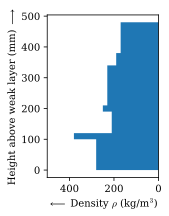

In [5]:
weac.plot.slab_profile(pst_cut_right)

### Analyze skier-induced stresses and deformations
---

In [6]:
# Example with two segements, one skier load
# (between segments 1 & 2) and no crack.

#                   |
#                   v
# +-----------------+-----------------+
# |                 |                 |
# |        1        |        2        |
# |                 |                 |
# +-----------------+-----------------+
#  |||||||||||||||||||||||||||||||||||
# --------------------------------------

In [7]:
# Input
totallength = 1e4                       # Total length (mm)
cracklength = 0                         # Crack length (mm)
inclination = 30                        # Slope inclination (°)
skierweight = 80                        # Skier weigth (kg)

# Obtain lists of segment lengths, locations of foundations,
# and position and magnitude of skier loads from inputs. We
# can choose to analyze the situtation before a crack appears
# even if a cracklength > 0 is set by replacing the 'crack'
# key thorugh the 'uncracked' key.
seg_skier = skier.calc_segments(
    L=totallength, a=cracklength, m=skierweight)['crack']

# Assemble system of linear equations and solve the
# boundary-value problem for free constants.
C_skier = skier.assemble_and_solve(
    phi=inclination, **seg_skier)

# Prepare the output by rasterizing the solution vector at all
# horizontal positions xq. The result is returned in the form
# of the ndarray zq. Also provides xb that only contains
# x-coordinates that lie on a foundation.
xq_skier, zq_skier, xb_skier = skier.rasterize_solution(
    C=C_skier, phi=inclination, **seg_skier)

#### Visualize slab deformations (contour plot)

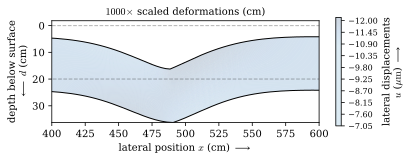

In [8]:
weac.plot.contours(skier, x=xq_skier, z=zq_skier, window=200, scale=1000)

#### Plot slab displacements

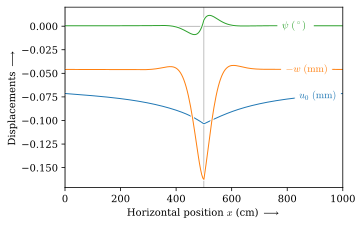

In [9]:
weac.plot.displacements(skier, x=xq_skier, z=zq_skier, **seg_skier)

#### Plot weak-layer stresses

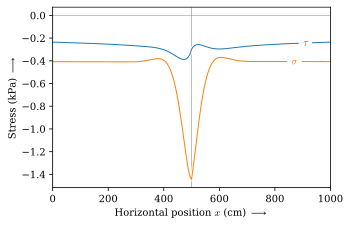

In [10]:
weac.plot.stresses(skier, x=xb_skier, z=zq_skier, **seg_skier)

### Propagation saw test
---

In [11]:
# Example with a crack cut from the right-hand side.

# +-----------------------------+-----+
# |                             |     |
# |             1               |  2  |
# |                             |     |
# +-----------------------------+-----+
#  |||||||||||||||||||||||||||||
# --------------------------------------

In [12]:
# Input
totallength = 2500                      # Total length (mm)
cracklength = 300                       # Crack length (mm)
inclination = -38                       # Slope inclination (°)

# Obtain lists of segment lengths, locations of foundations.
# We can choose to analyze the situtation before a crack
# appears even if a cracklength > 0 is set by replacing the
# 'crack' key thorugh the 'uncracked' key.
seg_pst = pst_cut_right.calc_segments(
    L=totallength, a=cracklength)['crack']

# Assemble system of linear equations and solve the
# boundary-value problem for free constants.
C_pst = pst_cut_right.assemble_and_solve(
    phi=inclination, **seg_pst)

# Prepare the output by rasterizing the solution vector at all
# horizontal positions xq. The result is returned in the form
# of the ndarray zq. Also provides xb that only contains
# x-coordinates that lie on a foundation.
xq_pst, zq_pst, xb_pst = pst_cut_right.rasterize_solution(
    C=C_pst, phi=inclination, **seg_pst)

#### Visualize slab deformations (contour plot)

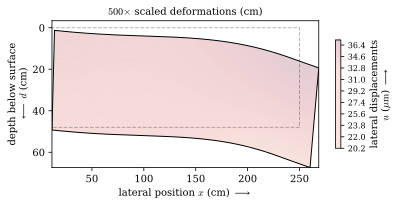

In [13]:
weac.plot.contours(pst_cut_right, x=xq_pst, z=zq_pst, scale=500)

#### Plot slab deformations

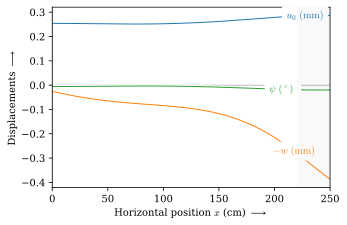

In [14]:
weac.plot.displacements(pst_cut_right, x=xq_pst, z=zq_pst, **seg_pst)

#### Plot weak-layer stresses

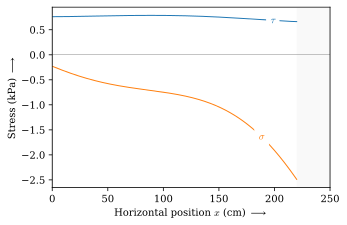

In [15]:
weac.plot.stresses(pst_cut_right, x=xb_pst, z=zq_pst, **seg_pst)

### Energy release rate in propagation saw tests
---

In [16]:
# Input
totallength = 1200                      # Total length (mm)
cracklength = 400                       # Maximum crack length (mm)
inclination = 30                        # Slope inclination (°)
n = 50                                  # Number of crack increments

# Initialize outputs and crack lengths
Gdif = np.zeros([3, n])
Ginc = np.zeros([3, n])
da = np.linspace(1e-6, cracklength, num=n)

# Loop through crack lengths
for i, a in enumerate(da):
    
    # Obtain lists of segment lengths, locations of foundations.
    seg_err = pst_cut_right.calc_segments(L=totallength, m=skierweight, a=a)
    
    # Assemble system and solve for free constants
    C0 = pst_cut_right.assemble_and_solve(phi=inclination, **seg_err['nocrack'])
    C1 = pst_cut_right.assemble_and_solve(phi=inclination, **seg_err['crack'])
    
    # Compute differential and incremental energy release rates
    Gdif[:, i] = pst_cut_right.gdif(C1, inclination, **seg_err['crack'])
    Ginc[:, i] = pst_cut_right.ginc(C0, C1, inclination, **seg_err['both'])

#### Plot differential energy release rate

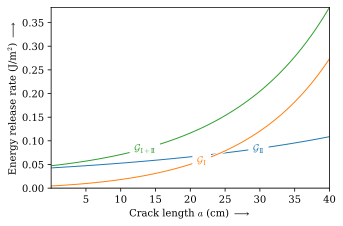

In [17]:
weac.plot.err_modes(da, Gdif, kind='dif')

### Multiple skiers
----

In [18]:
# Example with six segements, two skier loads (between
# segments 1 & 2 and 2 & 3) and a crack under segments
# 4 and 5

#           |   |
#           v   v
# +---------+---+-----+---+---+-------+
# |         |   |     |   |   |       |
# |    1    | 2 |  3  | 4 | 5 |   6   |
# |         |   |     |   |   |       |
# +---------+---+-----+---+---+-------+
#  |||||||||||||||||||         |||||||
# --------------------------------------

In [19]:
# Input
li = [5e3, 10e2, 25e2, 3e2, 3e2, 5e3]           # Beam segment lengths (mm)
ki = [True, True, True, False, False, True]     # Foundation (bedded/free = True/False)
mi = [80, 80, 0, 0, 0]                          # Skier weights [kg]
inclination = -20                               # Slope inclination (°)

# Obtain lists of segment lengths, locations of foundations,
# and position and magnitude of skier loads from inputs. If,
# in addition, a list k0 is passed to calc_segments, we may
# replace the 'crack' key by the 'nocrack' key to toggle
# between cracked (ki) and uncracked (k0) configurations.
seg_skiers = skiers_on_B.calc_segments(
    li=li, ki=ki, mi=mi)['crack']

# Assemble system of linear equations and solve the
# boundary-value problem for free constants.
C_skiers = skiers_on_B.assemble_and_solve(
    phi=inclination, **seg_skiers)

# Prepare the output by rasterizing the solution vector at all
# horizontal positions xq. The result is returned in the form
# of the ndarray zq. Also provides xb that only contains
# x-coordinates that lie on a foundation.
xq_skiers, zq_skiers, xb_skiers = skiers_on_B.rasterize_solution(
    C=C_skiers, phi=inclination, **seg_skiers)

#### Visualize slab deformations (contour plot)

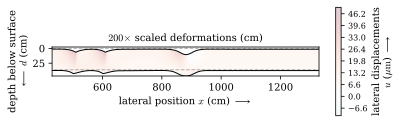

In [20]:
weac.plot.contours(
    skiers_on_B, x=xq_skiers, z=zq_skiers, window=900, scale=200)

#### Plot slab displacements

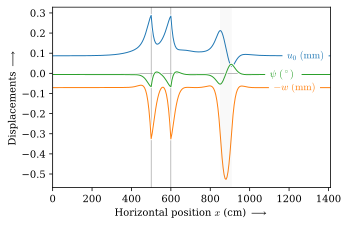

In [21]:
weac.plot.displacements(skiers_on_B, x=xq_skiers, z=zq_skiers, **seg_skiers)

#### Plot weak-layer stresses

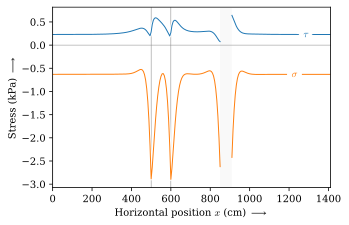

In [22]:
weac.plot.stresses(skiers_on_B, x=xb_skiers, z=zq_skiers, **seg_skiers)

#### Compare all outputs

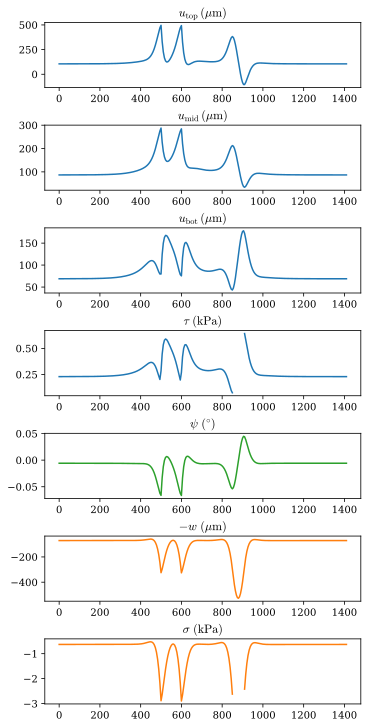

In [23]:
# === WEAK-LAYER OUTPUTS ===================================================

# Use only x-coordinates of bedded segments (xb)
x, z = xb_skiers, zq_skiers

# Compute stresses in kPa
xb_cm, tau = skiers_on_B.get_weaklayer_shearstress(x=x, z=z, unit='kPa')
_, sig = skiers_on_B.get_weaklayer_normalstress(x=x, z=z, unit='kPa')

# === SLAB OUTPUTS ==========================================================

# Use x-coordinates of bedded and unsupported segments (xq)
x, z = xq_skiers, zq_skiers

# Compute deformations in um and degrees
xq_cm, w = skiers_on_B.get_slab_deflection(x=x, z=z, unit='um')
_, u_top = skiers_on_B.get_slab_displacement(x=x, z=z, unit='um', loc='top')
_, u_mid = skiers_on_B.get_slab_displacement(x=x, z=z, unit='um', loc='mid')
_, u_bot = skiers_on_B.get_slab_displacement(x=x, z=z, unit='um', loc='bot')
_, psi = skiers_on_B.get_slab_rotation(x=x, z=z, unit='degrees')

# === ASSEMBLE ALL OUTPUTS INTO LISTS =======================================

outputs = [u_top, u_mid, u_bot, tau, psi, -w, sig]

names = [
    r'$u_\mathrm{top}\,(\mu\mathrm{m})$',
    r'$u_\mathrm{mid}\,(\mu\mathrm{m})$',
    r'$u_\mathrm{bot}\,(\mu\mathrm{m})$',
    r'$\tau\ (\mathrm{kPa})$',
    r'$\psi\ (\!^\circ\!)$',
    r'$-w\ (\mu\mathrm{m})$',
    r'$\sigma\ (\mathrm{kPa})$'
]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
coloridx = [0, 0, 0, 0, 2, 1, 1]

# === PLOT ALL OUTPUTS ======================================================

fig, axs = plt.subplots(7, 1, constrained_layout=True, figsize=(5,10))
for i, ax in enumerate(fig.get_axes()):
    ax.plot(xq_cm, outputs[i], color=colors[coloridx[i]])
    ax.set_title(names[i])